In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

# --- Hyperparameters ---
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_path = '/home/anhkhoa/ml4secu/save_path'
datapath = '/home/anhkhoa/ml4secu/data.csv'

# --- Load Dataset ---
train_dataset = simDataset(datapath=datapath, device=device, split='train')
test_dataset = simDataset(datapath=datapath, device=device, split='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# FGSM Attack

In [ ]:
import numpy as np

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

model = load_model(model, os.path.join(save_path, f'{model.model_name}.pth'))
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()


# --- Khởi tạo Solver ---
solver = Solver(args)
criterion = nn.CrossEntropyLoss()

accuracy_list = []
accuracy_before_defense_adv_list = []

for epsilon in np.arange(0, 0.11, 0.01):
    accuracy, accuracy_adv = solver.generate(
        num_sample=1000,
        target=None,
        epsilon=epsilon,
        alpha=0.01,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_before_defense_adv_list.append(accuracy_adv)




In [ ]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 0.11, 0.01))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_list, label='Accuracy (clean)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy (adversarial)', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Adversarial Training - FGSM Defense

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from attacks.universal_backdoor_attacks import universal_backdoor_attack
from utils.dataset import simDataset
from models.models import LSTM
from attacks.fgsm import Attack , Solver
from utils.dataset import load_model
import os

model = LSTM().to(device)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))

# --- Gói các tham số vào args giả lập ---
class Args:
    def __init__(self):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.cuda = torch.cuda.is_available()
        self.epoch = num_epochs
        self.batch_size = 32
        self.eps = 0.03
        self.lr = learning_rate
        self.y_dim = 2
        self.dataset = 'fraud'
        self.data_loader = {
            'train': train_loader,
            'test': test_loader
        }
        self.save_path = save_path

args = Args()

# --- Khởi tạo Solver ---
solver = Solver(args)

solver.adv_train(train_loader=train_loader, val_loader=test_loader, num_epochs=num_epochs, alpha = 0.01, eps = 0.1)

In [ ]:
model = load_model(model, os.path.join(save_path, f'{model.model_name}_adv.pth'))
solver.model = model

accuracy_list = []
accuracy_after_defense_adv_list = []
import numpy as np
for epsilon in np.arange(0, 0.11, 0.01):
    accuracy, accuracy_adv = solver.generate(
        num_sample=1000,
        target=None,
        epsilon=epsilon,
        alpha=0.01,
        iteration=10
    )
    accuracy_list.append(accuracy)
    accuracy_after_defense_adv_list.append(accuracy_adv)

In [ ]:
import matplotlib.pyplot as plt
epsilon_values = list(np.arange(0, 0.11, 0.01))
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracy_after_defense_adv_list, label='Accuracy after defense (adversarial)')
plt.plot(epsilon_values, accuracy_before_defense_adv_list, label='Accuracy before defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FGSM Attack & After Adversarial Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Label Flipping poisoning Attack

In [ ]:
from defences.knn_based_defense import knn_based_defense
from attacks.falfa import falfa
from utils.dataset import save_model, load_model_state
import numpy as np


range_attack = np.arange(0, 0.5, 0.05)

In [ ]:
range_attack

## Train and save clean model

In [ ]:
model = LSTM().to(device)

# Loss function and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = nn.CrossEntropyLoss() # Others loss function use
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from tqdm import tqdm

# Train the network
model.train()  # Set model to training mode
for epoch in range(num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(train_loader, 
                       desc=f'Epoch {epoch+1}/{num_epochs}', 
                       unit='batch')
    
    for batch_id, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.type_as(outputs)
        loss = criterion(outputs.squeeze(), labels.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': running_loss/(batch_id+1)})
    
    print(f'Epoch {epoch+1} - Avg Loss: {running_loss/len(train_loader):.4f}')

save_model(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

In [ ]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # Others loss function use
from torch.utils.data import DataLoader, TensorDataset
num_epochs = 3

accu_poisend_list = []
accu_defense_list = []

for eps in range_attack:
    model_attack , optimizer_attack = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

    falfa_runner = falfa(
        model=model_attack,
        device=device,
        epochs=num_epochs,
        epsilon=eps,           
        max_iter=1,
        criterion=criterion,
        optimizer=optimizer_attack
    )


    poisoned_labels = falfa_runner.falfa_attack_dl_dataloader(
        dataloader=train_loader,
        X_np=train_dataset.x,
        y_np=train_dataset.y
    )


    X_tensor = torch.tensor(train_dataset.x, dtype=torch.float)
    y_poisoned_tensor = torch.tensor(poisoned_labels, dtype=torch.int64)
    poisoned_dataset = TensorDataset(X_tensor, y_poisoned_tensor)
    poisoned_loader = DataLoader(poisoned_dataset, batch_size=32, shuffle=True)
    
    falfa_runner.poisoned_labels = poisoned_labels
    falfa_runner.train_model_on_loader(poisoned_loader)

    accu_poisned = falfa_runner.evaluate_model(
        dataloader = test_loader,
        device = 'cuda'
    )

    accu_poisend_list.append(accu_poisned)
    print(f"Accuracy after attack: {accu_poisned:.4f}")

    # --- KNN-based Defense ---
    
    knn_defense = knn_based_defense(k = 5, eta = 0.6) # 5, 0.8
    cleaned_train_loader = knn_defense.apply_defense(
        X  = train_dataset.x,
        y_poisoned = poisoned_labels,
        y_clean = train_dataset.y,
    )

    model_clean , optimizer_clean = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))

    model_defensed = knn_defense.train_model_after_defense(
        model = model_clean,
        optimizer = optimizer_clean,
        cleaned_loader = cleaned_train_loader,
        num_epochs = num_epochs,
        criterion = criterion
    )

    # Evaluate the model after defense
    accuracy_defense = knn_defense.evaluate_model(
        model = model_defensed,
        test_loader = test_loader,
        device = 'cuda'
    )

    accu_defense_list.append(accuracy_defense)
    
    print(f"Accuracy after defense: {accuracy_defense:.4f}")


In [ ]:
import matplotlib.pyplot as plt
range_attack = np.arange(0, 0.5, 0.05)
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range_attack, accu_poisend_list, label='Accuracy after defense (adversarial)')
plt.plot(range_attack, accu_defense_list, label='Accuracy before defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under FALFA Attack & After KNN Defense')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Spectral Signature Defense & Pruning Defense

In [9]:
from defences.ss_for_backdoor import spectral_signature_defense, plotCorrelationScores, extract_features
from defences.pruning_for_backdoor import extract_features, compute_average_activations, get_prune_indices, create_pruning_mask, PrunedFC
from torch.utils.data import Subset
from utils.dataset import load_model_state
import numpy as np

In [6]:
# --- Initialize Model ---
num_epochs = 3
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

eps_range = np.arange(0.05, 0.75, 0.05)

accu_before_attack_list = []
accu_after_defense_list = []

for eps in eps_range:
    # --- Initialize Attack ---
    attack = universal_backdoor_attack(
        device=device,
        model=model,
        data_obj=(train_loader, test_loader),
        target_label=0,
        mu=0.1,
        beta=0.01,
        lambd=0.01,
        epsilon=1.0,
        save_path=save_path
    )
    from utils.dataset import load_model_state
    import os
    model, optimizer = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))
    attack.model = model


    # --- Select & Rank ---
    attack.select_non_target_samples(train_dataset.get_data()) # select het non target samples , target 0 , non target 1 
    attack.confidence_based_sample_ranking(batch_size=32) # 

    # --- Trigger Creation ---
    attack.define_trigger(train_dataset.get_data())
    attack.compute_mode(train_dataset.get_data())
    attack.optimize_trigger(num_epochs=100)
    # attack.load_trigger('/home/anhkhoa/ml4secu/save_path/saved_triggers/trigger_delta.pt')

    print("✅ Trigger optimized:\n", attack.delta)
    print("✅ Mode vector:\n", attack.mode_vector)

    # # --- Poison Datasets ---
    poisoned_trainset, poisoned_train_samples = attack.construct_poisoned_dataset(train_dataset.get_data(), epsilon=eps)
    poisoned_testset, poisoned_test_samples = attack.construct_poisoned_dataset(test_dataset.get_data(), epsilon=1.0)
    # attack.load_poisoned_dataset('/home/anhkhoa/ml4secu/save_path/saved_datasets/poisoned_dataset.pt')

    # poisoned_trainset, poisoned_testset = attack.poisoned_dataset   


    model = LSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    attack.model = model
    # --- Reload DataLoaders ---
    poisoned_train_loader = DataLoader(poisoned_trainset, batch_size=32, shuffle=True)
    poisoned_test_loader = DataLoader(poisoned_testset, batch_size=32, shuffle=False)

    # --- Train on Poisoned Dataset ---
    attack.train((poisoned_train_loader, poisoned_test_loader), num_epochs, criterion, optimizer)

    acc_attack, asr = attack.generate(
        clean_dataset=train_dataset,
    )

    accu_before_attack_list.append(acc_attack)

    poisoned_indices = []
        # 
    poisoned_samples_set = set(tuple(sample.tolist()) for sample, _ in poisoned_train_samples)

    # Iterate over poisoned_trainset to find indices of poisoned samples
    for idx, (sample, _) in enumerate(poisoned_trainset):
        # Convert the sample to a tuple for comparison
        sample_tuple = tuple(sample.tolist())
        
        # Check if the sample is in the poisoned_samples_set
        if sample_tuple in poisoned_samples_set:
            poisoned_indices.append(idx)


    features = extract_features(model, poisoned_trainset)

    labels = poisoned_trainset.tensors[-1].cpu().numpy()

    class_list = [num for num in range(len(set(labels)))]

    suspicious_idx, scores_dict = spectral_signature_defense(
        features,
        labels=labels,
        class_list=class_list,
        expected_poison_fraction=0.4,
        extra_multiplier=2
    )
    suspicious_set = set(suspicious_idx)
    all_indices = list(range(len(poisoned_trainset)))
    clean_indices = [i for i in all_indices if i not in suspicious_set]

    X_tensor = poisoned_trainset.tensors[0][clean_indices]
    y_tensor = poisoned_trainset.tensors[1][clean_indices]

    X = X_tensor.detach().cpu().numpy()
    y = y_tensor.detach().cpu().numpy()

    # Tạo lại dataset cùng class gốc
    cleaned_trainset = simDataset(X = X , y = y, device = 'cuda')
    model = LSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    attack.model = model
    cleaned_train_loader = DataLoader(cleaned_trainset, batch_size=32, shuffle=True)
    attack.train((cleaned_train_loader, test_loader), num_epochs=3, criterion=criterion, optimizer=optimizer)

    acc_defensed , asr = attack.generate(
        clean_dataset=cleaned_trainset,
    )

    accu_after_defense_list.append(acc_defensed)

2025-05-14 01:07:24,990 - INFO - Attack initialized with target label: 0
2025-05-14 01:07:25,073 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:07:25,074 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:07:25,076 - INFO - Starting confidence-based sample ranking...
/home/anhkhoa/ml4secu/utils/dataset.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x[idx], dtype=torch.float).to(self.device)
/home/anhkhoa/ml4secu/utils/dataset.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.y[idx], dtype=torch.int64).to(self.device)


Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:07:25,899 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:07:25,917 - INFO - Selected 657 samples for further processing.
2025-05-14 01:07:25,919 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:07:25,920 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:07:25,922 - INFO - Min and max values computed successfully.
2025-05-14 01:07:25,924 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:07:25,924 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:07:25,933 - INFO - Mode vector computed successfully.
2025-05-14 01:07:25,933 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:07:27,057 - INFO - Epoch [10/100], Loss: 1.5369
2025-05-14 01:07:27,797 - INFO - Epoch [20/100], Loss: 1.5086
2025-05-14 01:07:28,466 - INFO - Epoch [30/100], Loss: 1.4816
2025-05-14 01:07:29,248 - INFO - E

✅ Trigger optimized:
 tensor([-0.1086, -0.0001,  0.0927,  0.0096,  0.1196,  0.0255, -0.0410],
       device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 112.68batch/s, loss=0.613]


Epoch 1 - Avg Loss: 0.6129


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 109.46batch/s, loss=0.594]


Epoch 2 - Avg Loss: 0.5935


Epoch 3/3: 100%|██████████| 411/411 [00:04<00:00, 102.63batch/s, loss=0.593]


Epoch 3 - Avg Loss: 0.5930


2025-05-14 01:07:45,789 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:07:45,790 - INFO - ASR (pred == target_label): 49.45%
2025-05-14 01:07:45,790 - INFO - Accuracy (pred == true label): 50.55%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 63.42batch/s, loss=0.635]


Epoch 1 - Avg Loss: 0.6350


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 92.78batch/s, loss=0.2]  


Epoch 2 - Avg Loss: 0.2002


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 90.43batch/s, loss=0.146]
2025-05-14 01:07:53,190 - INFO - [Generate Attack] Non-target triggered samples: 1253.
2025-05-14 01:07:53,191 - INFO - ASR (pred == target_label): 14.76%
2025-05-14 01:07:53,192 - INFO - Accuracy (pred == true label): 85.24%
2025-05-14 01:07:53,193 - INFO - Attack initialized with target label: 0
2025-05-14 01:07:53,239 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:07:53,240 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:07:53,241 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.1464
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:07:53,775 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:07:53,792 - INFO - Selected 657 samples for further processing.
2025-05-14 01:07:53,794 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:07:53,795 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:07:53,796 - INFO - Min and max values computed successfully.
2025-05-14 01:07:53,798 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:07:53,799 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:07:53,805 - INFO - Mode vector computed successfully.
2025-05-14 01:07:53,806 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:07:54,507 - INFO - Epoch [10/100], Loss: 1.6331
2025-05-14 01:07:55,216 - INFO - Epoch [20/100], Loss: 1.5765
2025-05-14 01:07:55,948 - INFO - Epoch [30/100], Loss: 1.5461
2025-05-14 01:07:56,597 - INFO - E

✅ Trigger optimized:
 tensor([-9.5156e-02,  2.1407e-05,  1.7307e-02, -2.7195e-02,  3.1237e-02,
         2.6429e-02, -1.4050e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 133.62batch/s, loss=0.611]


Epoch 1 - Avg Loss: 0.6114


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 135.72batch/s, loss=0.594]


Epoch 2 - Avg Loss: 0.5942


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 136.42batch/s, loss=0.559]


Epoch 3 - Avg Loss: 0.5588


2025-05-14 01:08:10,191 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:08:10,192 - INFO - ASR (pred == target_label): 85.40%
2025-05-14 01:08:10,193 - INFO - Accuracy (pred == true label): 14.60%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 78.65batch/s, loss=0.565]


Epoch 1 - Avg Loss: 0.5650


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 90.05batch/s, loss=0.441]


Epoch 2 - Avg Loss: 0.4413


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 93.11batch/s, loss=0.435]
2025-05-14 01:08:15,176 - INFO - [Generate Attack] Non-target triggered samples: 1179.
2025-05-14 01:08:15,177 - INFO - ASR (pred == target_label): 26.72%
2025-05-14 01:08:15,178 - INFO - Accuracy (pred == true label): 73.28%
2025-05-14 01:08:15,179 - INFO - Attack initialized with target label: 0
2025-05-14 01:08:15,214 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:08:15,215 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:08:15,216 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.4347
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:08:15,787 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:08:15,805 - INFO - Selected 657 samples for further processing.
2025-05-14 01:08:15,808 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:08:15,809 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:08:15,811 - INFO - Min and max values computed successfully.
2025-05-14 01:08:15,812 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:08:15,813 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:08:15,820 - INFO - Mode vector computed successfully.
2025-05-14 01:08:15,821 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:08:16,518 - INFO - Epoch [10/100], Loss: 1.6838
2025-05-14 01:08:17,182 - INFO - Epoch [20/100], Loss: 1.6101
2025-05-14 01:08:17,835 - INFO - Epoch [30/100], Loss: 1.5674
2025-05-14 01:08:18,532 - INFO - E

✅ Trigger optimized:
 tensor([-1.0771e-01,  3.0235e-05, -3.9817e-03, -8.2618e-03,  3.2136e-02,
         3.5183e-02, -5.9267e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 135.17batch/s, loss=0.613]


Epoch 1 - Avg Loss: 0.6127


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 137.98batch/s, loss=0.596]


Epoch 2 - Avg Loss: 0.5962


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 122.09batch/s, loss=0.487]
2025-05-14 01:08:32,595 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:08:32,596 - INFO - ASR (pred == target_label): 79.39%
2025-05-14 01:08:32,597 - INFO - Accuracy (pred == true label): 20.61%


Epoch 3 - Avg Loss: 0.4870


Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 72.78batch/s, loss=0.526]


Epoch 1 - Avg Loss: 0.5258


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 85.80batch/s, loss=0.413]


Epoch 2 - Avg Loss: 0.4131


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 88.76batch/s, loss=0.38] 
2025-05-14 01:08:38,741 - INFO - [Generate Attack] Non-target triggered samples: 1124.
2025-05-14 01:08:38,742 - INFO - ASR (pred == target_label): 18.59%
2025-05-14 01:08:38,743 - INFO - Accuracy (pred == true label): 81.41%
2025-05-14 01:08:38,744 - INFO - Attack initialized with target label: 0
2025-05-14 01:08:38,775 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:08:38,776 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:08:38,777 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.3805
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:08:39,299 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:08:39,314 - INFO - Selected 657 samples for further processing.
2025-05-14 01:08:39,316 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:08:39,317 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:08:39,319 - INFO - Min and max values computed successfully.
2025-05-14 01:08:39,320 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:08:39,321 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:08:39,326 - INFO - Mode vector computed successfully.
2025-05-14 01:08:39,326 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:08:40,087 - INFO - Epoch [10/100], Loss: 1.5332
2025-05-14 01:08:40,771 - INFO - Epoch [20/100], Loss: 1.5060
2025-05-14 01:08:41,483 - INFO - Epoch [30/100], Loss: 1.4800
2025-05-14 01:08:42,175 - INFO - E

✅ Trigger optimized:
 tensor([-1.0143e-01,  1.5274e-06,  1.0096e-01,  1.7659e-02,  1.1595e-01,
         4.3200e-02, -3.6989e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 141.91batch/s, loss=0.623]


Epoch 1 - Avg Loss: 0.6229


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 125.86batch/s, loss=0.598]


Epoch 2 - Avg Loss: 0.5977


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 127.80batch/s, loss=0.471]


Epoch 3 - Avg Loss: 0.4712


2025-05-14 01:08:56,140 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:08:56,141 - INFO - ASR (pred == target_label): 98.80%
2025-05-14 01:08:56,141 - INFO - Accuracy (pred == true label): 1.20%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 79.94batch/s, loss=0.566]


Epoch 1 - Avg Loss: 0.5663


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 95.37batch/s, loss=0.26]  


Epoch 2 - Avg Loss: 0.2601


Epoch 3/3: 100%|██████████| 83/83 [00:01<00:00, 73.21batch/s, loss=0.181]
2025-05-14 01:09:02,366 - INFO - [Generate Attack] Non-target triggered samples: 1064.
2025-05-14 01:09:02,367 - INFO - ASR (pred == target_label): 8.18%
2025-05-14 01:09:02,368 - INFO - Accuracy (pred == true label): 91.82%
2025-05-14 01:09:02,368 - INFO - Attack initialized with target label: 0
2025-05-14 01:09:02,402 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:09:02,403 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:09:02,405 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.1811
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:09:02,934 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:09:02,950 - INFO - Selected 657 samples for further processing.
2025-05-14 01:09:02,953 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:09:02,954 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:09:02,956 - INFO - Min and max values computed successfully.
2025-05-14 01:09:02,957 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:09:02,958 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:09:02,964 - INFO - Mode vector computed successfully.
2025-05-14 01:09:02,965 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:09:03,635 - INFO - Epoch [10/100], Loss: 1.5882
2025-05-14 01:09:04,353 - INFO - Epoch [20/100], Loss: 1.5451
2025-05-14 01:09:05,064 - INFO - Epoch [30/100], Loss: 1.5219
2025-05-14 01:09:05,739 - INFO - E

✅ Trigger optimized:
 tensor([-1.0676e-01, -2.1165e-05,  3.8019e-02, -2.5057e-02,  1.4967e-02,
         4.2854e-02, -1.3565e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 132.08batch/s, loss=0.611]


Epoch 1 - Avg Loss: 0.6109


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 133.06batch/s, loss=0.587]


Epoch 2 - Avg Loss: 0.5873


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 144.69batch/s, loss=0.588]
2025-05-14 01:09:19,174 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:09:19,175 - INFO - ASR (pred == target_label): 70.76%
2025-05-14 01:09:19,175 - INFO - Accuracy (pred == true label): 29.24%


Epoch 3 - Avg Loss: 0.5881


Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 83.81batch/s, loss=0.665]


Epoch 1 - Avg Loss: 0.6646


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 97.26batch/s, loss=0.228]


Epoch 2 - Avg Loss: 0.2284


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 89.07batch/s, loss=0.122] 
2025-05-14 01:09:24,486 - INFO - [Generate Attack] Non-target triggered samples: 983.
2025-05-14 01:09:24,487 - INFO - ASR (pred == target_label): 53.81%
2025-05-14 01:09:24,488 - INFO - Accuracy (pred == true label): 46.19%
2025-05-14 01:09:24,488 - INFO - Attack initialized with target label: 0
2025-05-14 01:09:24,519 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:09:24,520 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:09:24,521 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.1219
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:09:25,064 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:09:25,081 - INFO - Selected 657 samples for further processing.
2025-05-14 01:09:25,083 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:09:25,084 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:09:25,086 - INFO - Min and max values computed successfully.
2025-05-14 01:09:25,087 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:09:25,088 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:09:25,094 - INFO - Mode vector computed successfully.
2025-05-14 01:09:25,095 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:09:25,829 - INFO - Epoch [10/100], Loss: 1.5956
2025-05-14 01:09:26,566 - INFO - Epoch [20/100], Loss: 1.5557
2025-05-14 01:09:27,361 - INFO - Epoch [30/100], Loss: 1.5294
2025-05-14 01:09:28,053 - INFO - E

✅ Trigger optimized:
 tensor([-1.0458e-01,  7.0581e-06,  3.2195e-02, -2.4835e-02,  1.7701e-02,
         3.9541e-02, -1.4812e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 123.04batch/s, loss=0.598]


Epoch 1 - Avg Loss: 0.5985


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 123.60batch/s, loss=0.583]


Epoch 2 - Avg Loss: 0.5831


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 123.07batch/s, loss=0.578]


Epoch 3 - Avg Loss: 0.5782


2025-05-14 01:09:43,359 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:09:43,360 - INFO - ASR (pred == target_label): 74.64%
2025-05-14 01:09:43,361 - INFO - Accuracy (pred == true label): 25.36%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 75.31batch/s, loss=0.648]


Epoch 1 - Avg Loss: 0.6479


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 88.10batch/s, loss=0.572]


Epoch 2 - Avg Loss: 0.5724


Epoch 3/3: 100%|██████████| 83/83 [00:01<00:00, 74.70batch/s, loss=0.246]
2025-05-14 01:09:48,446 - INFO - [Generate Attack] Non-target triggered samples: 926.
2025-05-14 01:09:48,447 - INFO - ASR (pred == target_label): 47.30%
2025-05-14 01:09:48,447 - INFO - Accuracy (pred == true label): 52.70%
2025-05-14 01:09:48,448 - INFO - Attack initialized with target label: 0
2025-05-14 01:09:48,479 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:09:48,480 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:09:48,482 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.2459
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:09:49,026 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:09:49,041 - INFO - Selected 657 samples for further processing.
2025-05-14 01:09:49,043 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:09:49,044 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:09:49,046 - INFO - Min and max values computed successfully.
2025-05-14 01:09:49,047 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:09:49,047 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:09:49,054 - INFO - Mode vector computed successfully.
2025-05-14 01:09:49,055 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:09:49,731 - INFO - Epoch [10/100], Loss: 1.5234
2025-05-14 01:09:50,376 - INFO - Epoch [20/100], Loss: 1.4959
2025-05-14 01:09:51,070 - INFO - Epoch [30/100], Loss: 1.4710
2025-05-14 01:09:51,928 - INFO - E

✅ Trigger optimized:
 tensor([-1.1028e-01, -1.0459e-04,  1.0112e-01,  2.0075e-02,  1.1516e-01,
         4.5176e-02, -3.3357e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 112.85batch/s, loss=0.588]


Epoch 1 - Avg Loss: 0.5876


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 107.49batch/s, loss=0.407]


Epoch 2 - Avg Loss: 0.4067


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 126.07batch/s, loss=0.378]
2025-05-14 01:10:06,869 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:10:06,870 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:10:06,871 - INFO - Accuracy (pred == true label): 0.00%


Epoch 3 - Avg Loss: 0.3782


Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 81.76batch/s, loss=0.641]


Epoch 1 - Avg Loss: 0.6407


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 91.79batch/s, loss=0.555]


Epoch 2 - Avg Loss: 0.5552


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 88.58batch/s, loss=0.292]
2025-05-14 01:10:11,992 - INFO - [Generate Attack] Non-target triggered samples: 856.
2025-05-14 01:10:11,993 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:10:11,993 - INFO - Accuracy (pred == true label): 0.00%
2025-05-14 01:10:11,994 - INFO - Attack initialized with target label: 0
2025-05-14 01:10:12,027 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:10:12,028 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:10:12,029 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.2921
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:10:12,558 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:10:12,573 - INFO - Selected 657 samples for further processing.
2025-05-14 01:10:12,575 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:10:12,575 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:10:12,576 - INFO - Min and max values computed successfully.
2025-05-14 01:10:12,577 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:10:12,578 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:10:12,583 - INFO - Mode vector computed successfully.
2025-05-14 01:10:12,584 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:10:13,264 - INFO - Epoch [10/100], Loss: 1.5520
2025-05-14 01:10:13,945 - INFO - Epoch [20/100], Loss: 1.5151
2025-05-14 01:10:14,620 - INFO - Epoch [30/100], Loss: 1.4813
2025-05-14 01:10:15,276 - INFO - E

✅ Trigger optimized:
 tensor([-0.1243, -0.0009,  0.0746,  0.0186,  0.1052,  0.0217, -0.0443],
       device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 115.23batch/s, loss=0.572]


Epoch 1 - Avg Loss: 0.5720


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 114.92batch/s, loss=0.484]


Epoch 2 - Avg Loss: 0.4837


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 127.77batch/s, loss=0.365]


Epoch 3 - Avg Loss: 0.3654


2025-05-14 01:10:29,742 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:10:29,743 - INFO - ASR (pred == target_label): 99.91%
2025-05-14 01:10:29,744 - INFO - Accuracy (pred == true label): 0.09%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 74.55batch/s, loss=0.617]


Epoch 1 - Avg Loss: 0.6172


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 88.49batch/s, loss=0.598]


Epoch 2 - Avg Loss: 0.5982


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 89.02batch/s, loss=0.486]
2025-05-14 01:10:34,627 - INFO - [Generate Attack] Non-target triggered samples: 788.
2025-05-14 01:10:34,628 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:10:34,629 - INFO - Accuracy (pred == true label): 0.00%
2025-05-14 01:10:34,630 - INFO - Attack initialized with target label: 0
2025-05-14 01:10:34,671 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:10:34,672 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:10:34,673 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.4861
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:10:35,304 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:10:35,320 - INFO - Selected 657 samples for further processing.
2025-05-14 01:10:35,322 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:10:35,322 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:10:35,324 - INFO - Min and max values computed successfully.
2025-05-14 01:10:35,325 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:10:35,325 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:10:35,331 - INFO - Mode vector computed successfully.
2025-05-14 01:10:35,332 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:10:36,021 - INFO - Epoch [10/100], Loss: 1.5751
2025-05-14 01:10:36,719 - INFO - Epoch [20/100], Loss: 1.5372
2025-05-14 01:10:37,406 - INFO - Epoch [30/100], Loss: 1.4215
2025-05-14 01:10:38,100 - INFO - E

✅ Trigger optimized:
 tensor([-1.0520e-01, -1.4539e-02,  4.9856e-02,  2.1843e-02,  8.8719e-02,
        -1.5553e-05, -5.3114e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 123.51batch/s, loss=0.554]


Epoch 1 - Avg Loss: 0.5541


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 129.33batch/s, loss=0.487]


Epoch 2 - Avg Loss: 0.4868


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 122.41batch/s, loss=0.346]
2025-05-14 01:10:52,241 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:10:52,242 - INFO - ASR (pred == target_label): 99.16%
2025-05-14 01:10:52,243 - INFO - Accuracy (pred == true label): 0.84%


Epoch 3 - Avg Loss: 0.3455


Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 86.01batch/s, loss=0.597]


Epoch 1 - Avg Loss: 0.5974


Epoch 2/3: 100%|██████████| 83/83 [00:01<00:00, 75.59batch/s, loss=0.588]


Epoch 2 - Avg Loss: 0.5877


Epoch 3/3: 100%|██████████| 83/83 [00:01<00:00, 71.55batch/s, loss=0.546]
2025-05-14 01:10:57,852 - INFO - [Generate Attack] Non-target triggered samples: 716.
2025-05-14 01:10:57,853 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:10:57,854 - INFO - Accuracy (pred == true label): 0.00%
2025-05-14 01:10:57,855 - INFO - Attack initialized with target label: 0
2025-05-14 01:10:57,886 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:10:57,887 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:10:57,888 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.5456
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:10:58,473 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:10:58,493 - INFO - Selected 657 samples for further processing.
2025-05-14 01:10:58,496 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:10:58,497 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:10:58,499 - INFO - Min and max values computed successfully.
2025-05-14 01:10:58,500 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:10:58,501 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:10:58,508 - INFO - Mode vector computed successfully.
2025-05-14 01:10:58,510 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:10:59,210 - INFO - Epoch [10/100], Loss: 1.5973
2025-05-14 01:11:00,056 - INFO - Epoch [20/100], Loss: 1.5477
2025-05-14 01:11:00,759 - INFO - Epoch [30/100], Loss: 1.5199
2025-05-14 01:11:01,471 - INFO - E

✅ Trigger optimized:
 tensor([-1.0681e-01, -8.3444e-03,  5.4229e-02,  1.7146e-02,  9.6859e-02,
         6.7170e-06, -5.0882e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 123.84batch/s, loss=0.529]


Epoch 1 - Avg Loss: 0.5292


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 134.57batch/s, loss=0.487]


Epoch 2 - Avg Loss: 0.4869


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 129.52batch/s, loss=0.324]
2025-05-14 01:11:15,411 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:11:15,412 - INFO - ASR (pred == target_label): 98.66%
2025-05-14 01:11:15,413 - INFO - Accuracy (pred == true label): 1.34%


Epoch 3 - Avg Loss: 0.3237


Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 87.82batch/s, loss=0.57] 


Epoch 1 - Avg Loss: 0.5704


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 93.95batch/s, loss=0.561]


Epoch 2 - Avg Loss: 0.5613


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 96.48batch/s, loss=0.462]
2025-05-14 01:11:20,230 - INFO - [Generate Attack] Non-target triggered samples: 649.
2025-05-14 01:11:20,231 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:11:20,232 - INFO - Accuracy (pred == true label): 0.00%
2025-05-14 01:11:20,232 - INFO - Attack initialized with target label: 0
2025-05-14 01:11:20,262 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:11:20,263 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:11:20,264 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.4616
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:11:20,779 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:11:20,794 - INFO - Selected 657 samples for further processing.
2025-05-14 01:11:20,796 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:11:20,797 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:11:20,799 - INFO - Min and max values computed successfully.
2025-05-14 01:11:20,800 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:11:20,801 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:11:20,806 - INFO - Mode vector computed successfully.
2025-05-14 01:11:20,807 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:11:21,466 - INFO - Epoch [10/100], Loss: 1.5898
2025-05-14 01:11:22,085 - INFO - Epoch [20/100], Loss: 1.5572
2025-05-14 01:11:22,693 - INFO - Epoch [30/100], Loss: 1.5338
2025-05-14 01:11:23,366 - INFO - E

✅ Trigger optimized:
 tensor([-1.0073e-01, -2.1844e-05,  4.6394e-02, -2.4834e-02,  2.1467e-02,
         4.6101e-02, -1.5274e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 137.37batch/s, loss=0.51] 


Epoch 1 - Avg Loss: 0.5096


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 137.85batch/s, loss=0.493]


Epoch 2 - Avg Loss: 0.4931


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 128.74batch/s, loss=0.49] 
2025-05-14 01:11:36,823 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:11:36,825 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:11:36,826 - INFO - Accuracy (pred == true label): 0.00%


Epoch 3 - Avg Loss: 0.4904


Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 94.97batch/s, loss=0.545]


Epoch 1 - Avg Loss: 0.5450


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 96.35batch/s, loss=0.543]


Epoch 2 - Avg Loss: 0.5427


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 96.67batch/s, loss=0.33] 
2025-05-14 01:11:41,477 - INFO - [Generate Attack] Non-target triggered samples: 596.
2025-05-14 01:11:41,478 - INFO - ASR (pred == target_label): 80.87%
2025-05-14 01:11:41,479 - INFO - Accuracy (pred == true label): 19.13%
2025-05-14 01:11:41,480 - INFO - Attack initialized with target label: 0
2025-05-14 01:11:41,512 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:11:41,513 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:11:41,514 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.3296
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:11:42,034 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:11:42,049 - INFO - Selected 657 samples for further processing.
2025-05-14 01:11:42,051 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:11:42,051 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:11:42,054 - INFO - Min and max values computed successfully.
2025-05-14 01:11:42,055 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:11:42,056 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:11:42,062 - INFO - Mode vector computed successfully.
2025-05-14 01:11:42,063 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:11:42,666 - INFO - Epoch [10/100], Loss: 1.5651
2025-05-14 01:11:43,256 - INFO - Epoch [20/100], Loss: 1.5409
2025-05-14 01:11:43,850 - INFO - Epoch [30/100], Loss: 1.5173
2025-05-14 01:11:44,446 - INFO - E

✅ Trigger optimized:
 tensor([-7.9178e-02,  3.2260e-05,  9.7883e-02, -1.3109e-02,  4.4294e-02,
         7.6603e-02, -1.9831e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 142.72batch/s, loss=0.458]


Epoch 1 - Avg Loss: 0.4577


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 116.38batch/s, loss=0.307]


Epoch 2 - Avg Loss: 0.3072


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 117.29batch/s, loss=0.246]


Epoch 3 - Avg Loss: 0.2460


2025-05-14 01:11:58,528 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:11:58,530 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:11:58,531 - INFO - Accuracy (pred == true label): 0.00%
Epoch 1/3: 100%|██████████| 83/83 [00:01<00:00, 81.78batch/s, loss=0.514]


Epoch 1 - Avg Loss: 0.5141


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 93.94batch/s, loss=0.497]


Epoch 2 - Avg Loss: 0.4973


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 98.12batch/s, loss=0.404]
2025-05-14 01:12:03,223 - INFO - [Generate Attack] Non-target triggered samples: 521.
2025-05-14 01:12:03,224 - INFO - ASR (pred == target_label): 90.21%
2025-05-14 01:12:03,224 - INFO - Accuracy (pred == true label): 9.79%
2025-05-14 01:12:03,225 - INFO - Attack initialized with target label: 0
2025-05-14 01:12:03,258 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:12:03,259 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:12:03,260 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.4042
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:12:03,784 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:12:03,806 - INFO - Selected 657 samples for further processing.
2025-05-14 01:12:03,808 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:12:03,810 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:12:03,812 - INFO - Min and max values computed successfully.
2025-05-14 01:12:03,813 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:12:03,814 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:12:03,819 - INFO - Mode vector computed successfully.
2025-05-14 01:12:03,820 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:12:04,427 - INFO - Epoch [10/100], Loss: 1.5587
2025-05-14 01:12:05,028 - INFO - Epoch [20/100], Loss: 1.5296
2025-05-14 01:12:05,628 - INFO - Epoch [30/100], Loss: 1.5034
2025-05-14 01:12:06,241 - INFO - E

✅ Trigger optimized:
 tensor([-9.1168e-02, -4.4000e-05,  1.0375e-01,  1.2549e-02,  1.1952e-01,
         4.0453e-02, -3.8691e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 133.49batch/s, loss=0.451]


Epoch 1 - Avg Loss: 0.4506


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 146.09batch/s, loss=0.304]


Epoch 2 - Avg Loss: 0.3036


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 147.71batch/s, loss=0.218]
2025-05-14 01:12:18,988 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:12:18,989 - INFO - ASR (pred == target_label): 99.97%
2025-05-14 01:12:18,990 - INFO - Accuracy (pred == true label): 0.03%


Epoch 3 - Avg Loss: 0.2178


Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 90.70batch/s, loss=0.485]


Epoch 1 - Avg Loss: 0.4849


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 90.78batch/s, loss=0.459]


Epoch 2 - Avg Loss: 0.4587


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 97.32batch/s, loss=0.336]
2025-05-14 01:12:24,078 - INFO - [Generate Attack] Non-target triggered samples: 463.
2025-05-14 01:12:24,079 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 01:12:24,080 - INFO - Accuracy (pred == true label): 0.00%
2025-05-14 01:12:24,082 - INFO - Attack initialized with target label: 0
2025-05-14 01:12:24,114 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:12:24,115 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:12:24,117 - INFO - Starting confidence-based sample ranking...


Epoch 3 - Avg Loss: 0.3355
Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:12:24,613 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:12:24,628 - INFO - Selected 657 samples for further processing.
2025-05-14 01:12:24,630 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:12:24,631 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:12:24,633 - INFO - Min and max values computed successfully.
2025-05-14 01:12:24,635 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:12:24,636 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:12:24,642 - INFO - Mode vector computed successfully.
2025-05-14 01:12:24,643 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:12:25,286 - INFO - Epoch [10/100], Loss: 1.5532
2025-05-14 01:12:25,885 - INFO - Epoch [20/100], Loss: 1.5214
2025-05-14 01:12:26,499 - INFO - Epoch [30/100], Loss: 1.4918
2025-05-14 01:12:27,086 - INFO - E

✅ Trigger optimized:
 tensor([-0.1148, -0.0066,  0.0804,  0.0042,  0.1184,  0.0052, -0.0462],
       device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 142.68batch/s, loss=0.408]


Epoch 1 - Avg Loss: 0.4082


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 144.59batch/s, loss=0.301]


Epoch 2 - Avg Loss: 0.3012


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 142.50batch/s, loss=0.191]
2025-05-14 01:12:39,536 - INFO - [Generate Attack] Non-target triggered samples: 6576.


Epoch 3 - Avg Loss: 0.1905


2025-05-14 01:12:39,537 - INFO - ASR (pred == target_label): 99.98%
2025-05-14 01:12:39,538 - INFO - Accuracy (pred == true label): 0.02%
Epoch 1/3: 100%|██████████| 83/83 [00:00<00:00, 86.05batch/s, loss=0.434]


Epoch 1 - Avg Loss: 0.4344


Epoch 2/3: 100%|██████████| 83/83 [00:00<00:00, 89.47batch/s, loss=0.415]


Epoch 2 - Avg Loss: 0.4153


Epoch 3/3: 100%|██████████| 83/83 [00:00<00:00, 94.91batch/s, loss=0.281]
2025-05-14 01:12:45,762 - INFO - [Generate Attack] Non-target triggered samples: 390.
2025-05-14 01:12:45,763 - INFO - ASR (pred == target_label): 46.92%
2025-05-14 01:12:45,764 - INFO - Accuracy (pred == true label): 53.08%


Epoch 3 - Avg Loss: 0.2811


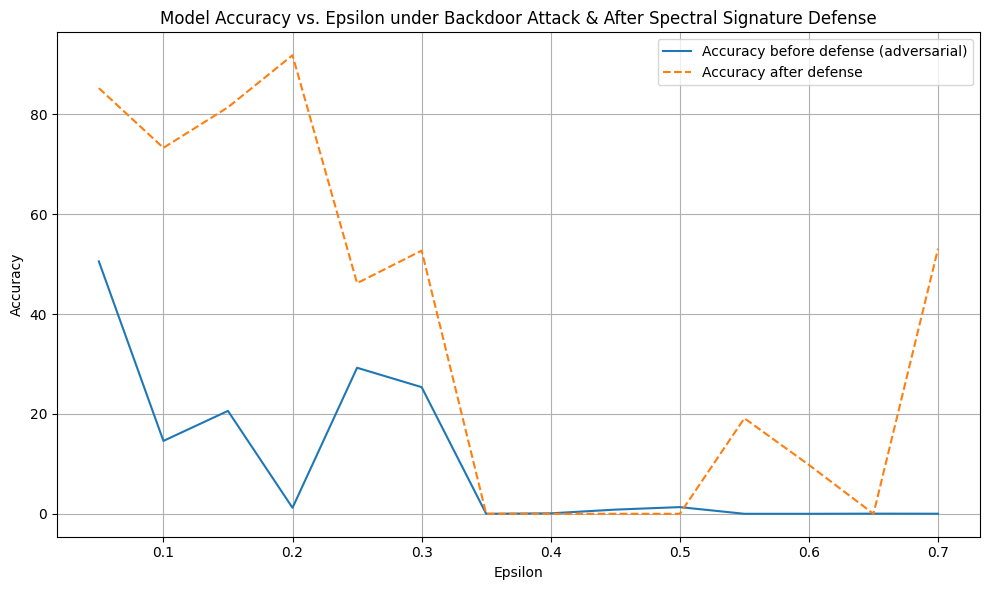

In [10]:
import matplotlib.pyplot as plt
range_attack = np.arange(0.05, 0.75, 0.05)
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range_attack, accu_before_attack_list, label='Accuracy before defense (adversarial)')
plt.plot(range_attack, accu_after_defense_list , label='Accuracy after defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon under Backdoor Attack & After Spectral Signature Defense')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Pruning Defense

In [13]:
# --- Initialize Model ---
num_epochs = 3
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

eps_range = np.arange(0.05, 0.75, 0.05)

accu_before_attack_list = []
accu_after_defense_list = []

for eps in eps_range:
    # --- Initialize Attack ---
    attack = universal_backdoor_attack(
        device=device,
        model=model,
        data_obj=(train_loader, test_loader),
        target_label=0,
        mu=0.1,
        beta=0.01,
        lambd=0.01,
        epsilon=1.0,
        save_path=save_path
    )
    from utils.dataset import load_model_state
    import os
    model, optimizer = load_model_state(model, optimizer, os.path.join(save_path, f'{model.model_name}_falfa'))
    attack.model = model


    # --- Select & Rank ---
    attack.select_non_target_samples(train_dataset.get_data()) # select het non target samples , target 0 , non target 1 
    attack.confidence_based_sample_ranking(batch_size=32) # 

    # --- Trigger Creation ---
    attack.define_trigger(train_dataset.get_data())
    attack.compute_mode(train_dataset.get_data())
    attack.optimize_trigger(num_epochs=100)
    # attack.load_trigger('/home/anhkhoa/ml4secu/save_path/saved_triggers/trigger_delta.pt')

    print("✅ Trigger optimized:\n", attack.delta)
    print("✅ Mode vector:\n", attack.mode_vector)

    # # --- Poison Datasets ---
    poisoned_trainset, poisoned_train_samples = attack.construct_poisoned_dataset(train_dataset.get_data(), epsilon=eps)
    poisoned_testset, poisoned_test_samples = attack.construct_poisoned_dataset(test_dataset.get_data(), epsilon=1.0)
    # attack.load_poisoned_dataset('/home/anhkhoa/ml4secu/save_path/saved_datasets/poisoned_dataset.pt')

    # poisoned_trainset, poisoned_testset = attack.poisoned_dataset   


    model = LSTM().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    attack.model = model
    # --- Reload DataLoaders ---
    poisoned_train_loader = DataLoader(poisoned_trainset, batch_size=32, shuffle=True)
    poisoned_test_loader = DataLoader(poisoned_testset, batch_size=32, shuffle=False)

    # --- Train on Poisoned Dataset ---
    attack.train((poisoned_train_loader, poisoned_test_loader), num_epochs, criterion, optimizer)

    acc_attack, asr = attack.generate(
        clean_dataset=train_dataset,
    )

    accu_before_attack_list.append(acc_attack)

    poisoned_indices = []
        # 
    poisoned_samples_set = set(tuple(sample.tolist()) for sample, _ in poisoned_train_samples)

    # Iterate over poisoned_trainset to find indices of poisoned samples
    for idx, (sample, _) in enumerate(poisoned_trainset):
        # Convert the sample to a tuple for comparison
        sample_tuple = tuple(sample.tolist())
        
        # Check if the sample is in the poisoned_samples_set
        if sample_tuple in poisoned_samples_set:
            poisoned_indices.append(idx)


    print("==> [Step 1] Gathering Activations on Clean Data...")
    activations_all = extract_features(model, train_dataset, device = device)

    print("    Activations shape:", activations_all.shape)  # e.g., [N, nFeats*dim]

    print("==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...")

    prune_rate = 0.9

    mean_acts = compute_average_activations(activations_all)
    prune_inds = get_prune_indices(mean_acts, prune_rate)

    print(f"    total dims: {mean_acts.numel()}, prune {len(prune_inds)} dims ({prune_rate*100}%).")

    print("==> [Step 3] inject pruning mask into the model ...")
           
    mask = create_pruning_mask(mean_acts.numel(), prune_inds, device)

    print("==> [Step 4] Inject pruning mask into LSTM model...")
    model.fc = PrunedFC(model.fc, mask)

    print("==> [Step 5] Fine-tuning the pruned model...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Dùng lại train_loader đã có
    for epoch in range(3):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    
        print(f"Epoch {epoch+1}/5, Loss: {total_loss/len(train_loader):.4f}")
    
    print("==> [Step 6] Testing pruned model on clean data...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"Accuracy after pruning: {100 * correct / total:.2f}%")

    attack.model = model
    acc_defensed, asr = attack.generate(
        clean_dataset=train_dataset,
    )

    accu_after_defense_list.append(acc_defensed)

2025-05-14 01:54:15,612 - INFO - Attack initialized with target label: 0
2025-05-14 01:54:15,681 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:54:15,682 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:54:15,684 - INFO - Starting confidence-based sample ranking...
/home/anhkhoa/ml4secu/utils/dataset.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.x[idx], dtype=torch.float).to(self.device)
/home/anhkhoa/ml4secu/utils/dataset.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.y[idx], dtype=torch.int64).to(self.device)


Model state loaded successfully from /home/anhkhoa/ml4secu/save_path/LSTM_falfa


2025-05-14 01:54:16,355 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:54:16,371 - INFO - Selected 657 samples for further processing.
2025-05-14 01:54:16,373 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:54:16,374 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:54:16,376 - INFO - Min and max values computed successfully.
2025-05-14 01:54:16,377 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:54:16,378 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:54:16,384 - INFO - Mode vector computed successfully.
2025-05-14 01:54:16,385 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:54:17,079 - INFO - Epoch [10/100], Loss: 1.5346
2025-05-14 01:54:17,758 - INFO - Epoch [20/100], Loss: 1.5011
2025-05-14 01:54:18,410 - INFO - Epoch [30/100], Loss: 1.4756
2025-05-14 01:54:19,053 - INFO - E

✅ Trigger optimized:
 tensor([-1.2232e-01, -1.9597e-05,  8.8367e-02,  2.1996e-02,  1.0787e-01,
         3.8390e-02, -3.8037e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 110.47batch/s, loss=0.608]


Epoch 1 - Avg Loss: 0.6077


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 134.32batch/s, loss=0.59] 


Epoch 2 - Avg Loss: 0.5896


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 142.78batch/s, loss=0.561]


Epoch 3 - Avg Loss: 0.5609


2025-05-14 01:54:32,885 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:54:32,886 - INFO - ASR (pred == target_label): 93.04%
2025-05-14 01:54:32,887 - INFO - Accuracy (pred == true label): 6.96%


==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.3715
Epoch 2/5, Loss: 0.3063
Epoch 3/5, Loss: 0.2865
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:54:51,005 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:54:51,006 - INFO - ASR (pred == target_label): 40.66%
2025-05-14 01:54:51,007 - INFO - Accuracy (pred == true label): 59.34%
2025-05-14 01:54:51,008 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 87.83%


2025-05-14 01:54:51,044 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:54:51,045 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:54:51,059 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:54:51,523 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:54:51,547 - INFO - Selected 657 samples for further processing.
2025-05-14 01:54:51,552 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:54:51,552 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:54:51,554 - INFO - Min and max values computed successfully.
2025-05-14 01:54:51,555 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:54:51,556 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:54:51,562 - INFO - Mode vector computed successfully.
2025-05-14 01:54:51,562 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:54:52,198 - INFO - Epoch [10/100], Loss: 1.7912
2025-05-14 01:54:52,806 - INFO - Epoch [20/100], Loss: 1.7663
2025-05-14 01:54:53,412 - INFO - Epoch [30/100], Loss: 1.7459
2025-05-14 01:54:54,027 - INFO - E

✅ Trigger optimized:
 tensor([-1.0713e-01, -1.6903e-05,  9.3854e-02, -5.2883e-02,  4.5031e-03,
         2.4866e-02, -1.6870e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 118.45batch/s, loss=0.617]


Epoch 1 - Avg Loss: 0.6170


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 138.69batch/s, loss=0.597]


Epoch 2 - Avg Loss: 0.5966


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 143.13batch/s, loss=0.593]


Epoch 3 - Avg Loss: 0.5930


2025-05-14 01:55:07,314 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:55:07,315 - INFO - ASR (pred == target_label): 53.60%
2025-05-14 01:55:07,316 - INFO - Accuracy (pred == true label): 46.40%


==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5311
Epoch 2/5, Loss: 0.3333
Epoch 3/5, Loss: 0.3144
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:55:25,629 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:55:25,630 - INFO - ASR (pred == target_label): 16.56%
2025-05-14 01:55:25,631 - INFO - Accuracy (pred == true label): 83.44%
2025-05-14 01:55:25,632 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 85.76%


2025-05-14 01:55:25,675 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:55:25,676 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:55:25,682 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:55:26,111 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:55:26,128 - INFO - Selected 657 samples for further processing.
2025-05-14 01:55:26,130 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:55:26,132 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:55:26,134 - INFO - Min and max values computed successfully.
2025-05-14 01:55:26,135 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:55:26,136 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:55:26,142 - INFO - Mode vector computed successfully.
2025-05-14 01:55:26,143 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:55:26,796 - INFO - Epoch [10/100], Loss: 1.9579
2025-05-14 01:55:27,393 - INFO - Epoch [20/100], Loss: 1.9295
2025-05-14 01:55:28,018 - INFO - Epoch [30/100], Loss: 1.9080
2025-05-14 01:55:28,627 - INFO - E

✅ Trigger optimized:
 tensor([-1.0259e-01, -3.8708e-05,  9.7362e-02, -5.8358e-03,  8.7583e-03,
         5.8762e-02, -2.6491e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 124.59batch/s, loss=0.621]


Epoch 1 - Avg Loss: 0.6212


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 131.71batch/s, loss=0.601]


Epoch 2 - Avg Loss: 0.6008


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 141.79batch/s, loss=0.6]  
2025-05-14 01:55:42,014 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:55:42,015 - INFO - ASR (pred == target_label): 63.75%
2025-05-14 01:55:42,015 - INFO - Accuracy (pred == true label): 36.25%


Epoch 3 - Avg Loss: 0.5998
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.4654
Epoch 2/5, Loss: 0.3099
Epoch 3/5, Loss: 0.2986
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:56:00,784 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:56:00,785 - INFO - ASR (pred == target_label): 19.78%
2025-05-14 01:56:00,787 - INFO - Accuracy (pred == true label): 80.22%
2025-05-14 01:56:00,788 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 87.13%


2025-05-14 01:56:00,835 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:56:00,837 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:56:00,847 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:56:01,288 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:56:01,302 - INFO - Selected 657 samples for further processing.
2025-05-14 01:56:01,305 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:56:01,306 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:56:01,307 - INFO - Min and max values computed successfully.
2025-05-14 01:56:01,309 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:56:01,309 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:56:01,316 - INFO - Mode vector computed successfully.
2025-05-14 01:56:01,317 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:56:01,967 - INFO - Epoch [10/100], Loss: 1.8249
2025-05-14 01:56:02,591 - INFO - Epoch [20/100], Loss: 1.7942
2025-05-14 01:56:03,231 - INFO - Epoch [30/100], Loss: 1.7674
2025-05-14 01:56:03,841 - INFO - E

✅ Trigger optimized:
 tensor([-8.7025e-02,  4.4533e-06,  1.0941e-01, -3.5992e-02, -2.7513e-05,
        -7.6117e-05, -8.9589e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 146.09batch/s, loss=0.612]


Epoch 1 - Avg Loss: 0.6117


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 145.23batch/s, loss=0.601]


Epoch 2 - Avg Loss: 0.6015


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 146.25batch/s, loss=0.598]
2025-05-14 01:56:16,350 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:56:16,351 - INFO - ASR (pred == target_label): 56.28%
2025-05-14 01:56:16,352 - INFO - Accuracy (pred == true label): 43.72%


Epoch 3 - Avg Loss: 0.5981
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5809
Epoch 2/5, Loss: 0.5106
Epoch 3/5, Loss: 0.3338
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:56:33,700 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:56:33,701 - INFO - ASR (pred == target_label): 1.43%
2025-05-14 01:56:33,701 - INFO - Accuracy (pred == true label): 98.57%
2025-05-14 01:56:33,702 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 86.55%


2025-05-14 01:56:33,747 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:56:33,748 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:56:33,750 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:56:34,176 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:56:34,198 - INFO - Selected 657 samples for further processing.
2025-05-14 01:56:34,200 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:56:34,201 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:56:34,203 - INFO - Min and max values computed successfully.
2025-05-14 01:56:34,204 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:56:34,205 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:56:34,211 - INFO - Mode vector computed successfully.
2025-05-14 01:56:34,211 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:56:34,843 - INFO - Epoch [10/100], Loss: 2.3020
2025-05-14 01:56:35,436 - INFO - Epoch [20/100], Loss: 2.2468
2025-05-14 01:56:36,043 - INFO - Epoch [30/100], Loss: 2.2029
2025-05-14 01:56:36,670 - INFO - E

✅ Trigger optimized:
 tensor([-1.0685e-01, -1.1377e-01,  1.0564e-01, -2.8945e-03, -3.3389e-05,
         3.6714e-05,  4.1340e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 145.82batch/s, loss=0.596]


Epoch 1 - Avg Loss: 0.5962


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 132.10batch/s, loss=0.579]


Epoch 2 - Avg Loss: 0.5792


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 125.41batch/s, loss=0.457]
2025-05-14 01:56:50,163 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:56:50,164 - INFO - ASR (pred == target_label): 97.60%
2025-05-14 01:56:50,165 - INFO - Accuracy (pred == true label): 2.40%


Epoch 3 - Avg Loss: 0.4566
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.3068
Epoch 2/5, Loss: 0.2644
Epoch 3/5, Loss: 0.2511
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:57:08,399 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:57:08,400 - INFO - ASR (pred == target_label): 74.74%
2025-05-14 01:57:08,400 - INFO - Accuracy (pred == true label): 25.26%
2025-05-14 01:57:08,402 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 86.64%


2025-05-14 01:57:08,445 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:57:08,447 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:57:08,450 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:57:08,907 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:57:08,924 - INFO - Selected 657 samples for further processing.
2025-05-14 01:57:08,926 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:57:08,927 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:57:08,929 - INFO - Min and max values computed successfully.
2025-05-14 01:57:08,930 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:57:08,931 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:57:08,937 - INFO - Mode vector computed successfully.
2025-05-14 01:57:08,938 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:57:09,646 - INFO - Epoch [10/100], Loss: 2.4347
2025-05-14 01:57:10,315 - INFO - Epoch [20/100], Loss: 2.3883
2025-05-14 01:57:10,958 - INFO - Epoch [30/100], Loss: 2.3449
2025-05-14 01:57:11,596 - INFO - E

✅ Trigger optimized:
 tensor([-1.1411e-01, -1.2652e-01,  1.1970e-01, -2.2334e-03,  2.4028e-05,
         6.0131e-04,  3.9637e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 144.44batch/s, loss=0.594]


Epoch 1 - Avg Loss: 0.5945


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 143.69batch/s, loss=0.564]


Epoch 2 - Avg Loss: 0.5637


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 140.18batch/s, loss=0.541]
2025-05-14 01:57:24,371 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:57:24,372 - INFO - ASR (pred == target_label): 76.72%
2025-05-14 01:57:24,372 - INFO - Accuracy (pred == true label): 23.28%


Epoch 3 - Avg Loss: 0.5407
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5672
Epoch 2/5, Loss: 0.4568
Epoch 3/5, Loss: 0.3966
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:57:41,877 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:57:41,879 - INFO - ASR (pred == target_label): 77.49%
2025-05-14 01:57:41,880 - INFO - Accuracy (pred == true label): 22.51%
2025-05-14 01:57:41,881 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 79.34%


2025-05-14 01:57:41,929 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:57:41,930 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:57:41,931 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:57:42,371 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:57:42,386 - INFO - Selected 657 samples for further processing.
2025-05-14 01:57:42,389 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:57:42,390 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:57:42,392 - INFO - Min and max values computed successfully.
2025-05-14 01:57:42,393 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:57:42,394 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:57:42,400 - INFO - Mode vector computed successfully.
2025-05-14 01:57:42,401 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:57:43,053 - INFO - Epoch [10/100], Loss: 1.5692
2025-05-14 01:57:43,681 - INFO - Epoch [20/100], Loss: 1.5281
2025-05-14 01:57:44,294 - INFO - Epoch [30/100], Loss: 1.4951
2025-05-14 01:57:44,920 - INFO - E

✅ Trigger optimized:
 tensor([-1.0577e-01, -4.9036e-05,  8.6827e-02, -4.9919e-02,  1.9287e-05,
        -4.2331e-04, -2.1690e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 129.62batch/s, loss=0.586]


Epoch 1 - Avg Loss: 0.5860


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 136.92batch/s, loss=0.567]


Epoch 2 - Avg Loss: 0.5666


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 143.41batch/s, loss=0.563]
2025-05-14 01:57:57,958 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:57:57,960 - INFO - ASR (pred == target_label): 76.03%
2025-05-14 01:57:57,961 - INFO - Accuracy (pred == true label): 23.97%


Epoch 3 - Avg Loss: 0.5630
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5821
Epoch 2/5, Loss: 0.4529
Epoch 3/5, Loss: 0.2970
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:58:15,296 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:58:15,297 - INFO - ASR (pred == target_label): 37.55%
2025-05-14 01:58:15,298 - INFO - Accuracy (pred == true label): 62.45%
2025-05-14 01:58:15,299 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 87.31%


2025-05-14 01:58:15,334 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:58:15,336 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:58:15,337 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:58:15,770 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:58:15,785 - INFO - Selected 657 samples for further processing.
2025-05-14 01:58:15,787 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:58:15,787 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:58:15,789 - INFO - Min and max values computed successfully.
2025-05-14 01:58:15,790 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:58:15,791 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:58:15,797 - INFO - Mode vector computed successfully.
2025-05-14 01:58:15,797 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:58:16,475 - INFO - Epoch [10/100], Loss: 1.9589
2025-05-14 01:58:17,141 - INFO - Epoch [20/100], Loss: 1.9211
2025-05-14 01:58:17,777 - INFO - Epoch [30/100], Loss: 1.8972
2025-05-14 01:58:18,424 - INFO - E

✅ Trigger optimized:
 tensor([-1.0131e-01, -1.3260e-05,  7.1628e-02, -2.9100e-02, -7.9717e-06,
         2.5995e-02, -1.5150e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 142.57batch/s, loss=0.571]


Epoch 1 - Avg Loss: 0.5715


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 143.34batch/s, loss=0.554]


Epoch 2 - Avg Loss: 0.5542


Epoch 3/3: 100%|██████████| 411/411 [00:03<00:00, 131.25batch/s, loss=0.555]
2025-05-14 01:58:31,252 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:58:31,254 - INFO - ASR (pred == target_label): 62.94%
2025-05-14 01:58:31,255 - INFO - Accuracy (pred == true label): 37.06%


Epoch 3 - Avg Loss: 0.5549
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5852
Epoch 2/5, Loss: 0.5334
Epoch 3/5, Loss: 0.3970
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:58:48,477 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:58:48,477 - INFO - ASR (pred == target_label): 16.27%
2025-05-14 01:58:48,478 - INFO - Accuracy (pred == true label): 83.73%
2025-05-14 01:58:48,479 - INFO - Attack initialized with target label: 0
2025-05-14 01:58:48,509 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:58:48,510 - INFO - Selected 6576 non-target samples out of 13140 total training samples.


Accuracy after pruning: 86.61%
Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:58:48,515 - INFO - Starting confidence-based sample ranking...
2025-05-14 01:58:49,158 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:58:49,184 - INFO - Selected 657 samples for further processing.
2025-05-14 01:58:49,186 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:58:49,187 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:58:49,188 - INFO - Min and max values computed successfully.
2025-05-14 01:58:49,189 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:58:49,190 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:58:49,196 - INFO - Mode vector computed successfully.
2025-05-14 01:58:49,197 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:58:49,992 - INFO - Epoch [10/100], Loss: 1.5987
2025-05-14 01:58:50,966 - INFO - Epoch [20/100], Loss: 1.5709
2025-05-14 01:58:52

✅ Trigger optimized:
 tensor([-1.0749e-01, -1.5068e-05,  8.3039e-02, -5.4041e-02,  2.2949e-05,
        -4.7232e-05, -1.6730e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 140.15batch/s, loss=0.548]


Epoch 1 - Avg Loss: 0.5484


Epoch 2/3: 100%|██████████| 411/411 [00:03<00:00, 125.93batch/s, loss=0.536]


Epoch 2 - Avg Loss: 0.5358


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 143.11batch/s, loss=0.533]
2025-05-14 01:59:06,137 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:59:06,139 - INFO - ASR (pred == target_label): 92.76%
2025-05-14 01:59:06,139 - INFO - Accuracy (pred == true label): 7.24%


Epoch 3 - Avg Loss: 0.5328
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5835
Epoch 2/5, Loss: 0.5528
Epoch 3/5, Loss: 0.3904
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:59:23,553 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:59:23,554 - INFO - ASR (pred == target_label): 7.30%
2025-05-14 01:59:23,555 - INFO - Accuracy (pred == true label): 92.70%
2025-05-14 01:59:23,556 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 85.88%


2025-05-14 01:59:23,594 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:59:23,596 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:59:23,597 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:59:24,050 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:59:24,065 - INFO - Selected 657 samples for further processing.
2025-05-14 01:59:24,066 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:59:24,067 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:59:24,069 - INFO - Min and max values computed successfully.
2025-05-14 01:59:24,071 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:59:24,071 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:59:24,079 - INFO - Mode vector computed successfully.
2025-05-14 01:59:24,080 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:59:24,732 - INFO - Epoch [10/100], Loss: 2.4327
2025-05-14 01:59:25,356 - INFO - Epoch [20/100], Loss: 2.3835
2025-05-14 01:59:25,990 - INFO - Epoch [30/100], Loss: 2.3426
2025-05-14 01:59:26,612 - INFO - E

✅ Trigger optimized:
 tensor([-1.0248e-01, -1.0709e-01,  8.0112e-02, -2.1699e-02,  1.8687e-05,
        -3.0389e-05, -3.0174e-05], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 143.30batch/s, loss=0.515]


Epoch 1 - Avg Loss: 0.5155


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 146.02batch/s, loss=0.502]


Epoch 2 - Avg Loss: 0.5023


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 147.56batch/s, loss=0.501]
2025-05-14 01:59:39,012 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:59:39,013 - INFO - ASR (pred == target_label): 83.77%
2025-05-14 01:59:39,014 - INFO - Accuracy (pred == true label): 16.23%


Epoch 3 - Avg Loss: 0.5011
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5812
Epoch 2/5, Loss: 0.5252
Epoch 3/5, Loss: 0.4322
==> [Step 6] Testing pruned model on clean data...


2025-05-14 01:59:57,397 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 01:59:57,398 - INFO - ASR (pred == target_label): 26.13%
2025-05-14 01:59:57,399 - INFO - Accuracy (pred == true label): 73.87%
2025-05-14 01:59:57,401 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 81.53%


2025-05-14 01:59:57,459 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 01:59:57,460 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 01:59:57,461 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 01:59:57,916 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 01:59:57,931 - INFO - Selected 657 samples for further processing.
2025-05-14 01:59:57,932 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 01:59:57,933 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 01:59:57,935 - INFO - Min and max values computed successfully.
2025-05-14 01:59:57,936 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 01:59:57,937 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 01:59:57,943 - INFO - Mode vector computed successfully.
2025-05-14 01:59:57,943 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 01:59:58,622 - INFO - Epoch [10/100], Loss: 2.4091
2025-05-14 01:59:59,266 - INFO - Epoch [20/100], Loss: 2.3546
2025-05-14 01:59:59,917 - INFO - Epoch [30/100], Loss: 2.3132
2025-05-14 02:00:00,590 - INFO - E

✅ Trigger optimized:
 tensor([-9.8586e-02, -1.0143e-01,  1.0996e-01, -2.3694e-03, -2.4375e-05,
         1.3982e-02,  3.2336e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 136.93batch/s, loss=0.497]


Epoch 1 - Avg Loss: 0.4970


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 141.14batch/s, loss=0.429]


Epoch 2 - Avg Loss: 0.4289


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 144.56batch/s, loss=0.328]
2025-05-14 02:00:13,553 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:00:13,554 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 02:00:13,555 - INFO - Accuracy (pred == true label): 0.00%


Epoch 3 - Avg Loss: 0.3277
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5857
Epoch 2/5, Loss: 0.5716
Epoch 3/5, Loss: 0.4321
==> [Step 6] Testing pruned model on clean data...


2025-05-14 02:00:30,923 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:00:30,924 - INFO - ASR (pred == target_label): 67.52%
2025-05-14 02:00:30,925 - INFO - Accuracy (pred == true label): 32.48%
2025-05-14 02:00:30,926 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 84.66%


2025-05-14 02:00:30,968 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 02:00:30,969 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 02:00:30,971 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 02:00:31,439 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 02:00:31,454 - INFO - Selected 657 samples for further processing.
2025-05-14 02:00:31,456 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 02:00:31,457 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 02:00:31,458 - INFO - Min and max values computed successfully.
2025-05-14 02:00:31,460 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 02:00:31,461 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 02:00:31,467 - INFO - Mode vector computed successfully.
2025-05-14 02:00:31,468 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 02:00:32,129 - INFO - Epoch [10/100], Loss: 1.9180
2025-05-14 02:00:32,791 - INFO - Epoch [20/100], Loss: 1.8841
2025-05-14 02:00:33,450 - INFO - Epoch [30/100], Loss: 1.8615
2025-05-14 02:00:34,095 - INFO - E

✅ Trigger optimized:
 tensor([-1.2145e-01, -2.1443e-05,  1.0267e-01, -6.4951e-03,  6.1673e-03,
         6.9628e-02, -2.7233e-03], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 144.36batch/s, loss=0.479]


Epoch 1 - Avg Loss: 0.4786


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 144.49batch/s, loss=0.458]


Epoch 2 - Avg Loss: 0.4579


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 146.86batch/s, loss=0.422]
2025-05-14 02:00:46,568 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:00:46,569 - INFO - ASR (pred == target_label): 97.23%
2025-05-14 02:00:46,570 - INFO - Accuracy (pred == true label): 2.77%


Epoch 3 - Avg Loss: 0.4223
==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5839
Epoch 2/5, Loss: 0.5046
Epoch 3/5, Loss: 0.3734
==> [Step 6] Testing pruned model on clean data...


2025-05-14 02:01:04,655 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:01:04,656 - INFO - ASR (pred == target_label): 7.13%
2025-05-14 02:01:04,657 - INFO - Accuracy (pred == true label): 92.87%
2025-05-14 02:01:04,658 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 84.66%


2025-05-14 02:01:04,693 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 02:01:04,695 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 02:01:04,702 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 02:01:05,151 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 02:01:05,166 - INFO - Selected 657 samples for further processing.
2025-05-14 02:01:05,169 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 02:01:05,170 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 02:01:05,171 - INFO - Min and max values computed successfully.
2025-05-14 02:01:05,172 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 02:01:05,173 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 02:01:05,182 - INFO - Mode vector computed successfully.
2025-05-14 02:01:05,183 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 02:01:05,836 - INFO - Epoch [10/100], Loss: 2.2809
2025-05-14 02:01:06,499 - INFO - Epoch [20/100], Loss: 2.2330
2025-05-14 02:01:07,148 - INFO - Epoch [30/100], Loss: 2.1885
2025-05-14 02:01:07,800 - INFO - E

✅ Trigger optimized:
 tensor([-9.1414e-02, -9.9678e-02,  1.1000e-01, -1.2232e-02, -3.0626e-05,
         3.2470e-02,  2.7509e-05], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:03<00:00, 131.50batch/s, loss=0.443]


Epoch 1 - Avg Loss: 0.4432


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 143.41batch/s, loss=0.434]


Epoch 2 - Avg Loss: 0.4335


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 142.16batch/s, loss=0.428]


Epoch 3 - Avg Loss: 0.4277


2025-05-14 02:01:20,819 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:01:20,820 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 02:01:20,820 - INFO - Accuracy (pred == true label): 0.00%


==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5522
Epoch 2/5, Loss: 0.4002
Epoch 3/5, Loss: 0.2752
==> [Step 6] Testing pruned model on clean data...


2025-05-14 02:01:38,827 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:01:38,829 - INFO - ASR (pred == target_label): 45.26%
2025-05-14 02:01:38,830 - INFO - Accuracy (pred == true label): 54.74%
2025-05-14 02:01:38,831 - INFO - Attack initialized with target label: 0


Accuracy after pruning: 88.98%


2025-05-14 02:01:38,872 - INFO - Selecting non-target samples from the training dataset...
2025-05-14 02:01:38,873 - INFO - Selected 6576 non-target samples out of 13140 total training samples.
2025-05-14 02:01:38,877 - INFO - Starting confidence-based sample ranking...


Error loading model state: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "fc.pruning_mask", "fc.fc.weight", "fc.fc.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 


2025-05-14 02:01:39,327 - INFO - Selecting top 10.0% (657) samples based on confidence scores.
2025-05-14 02:01:39,349 - INFO - Selected 657 samples for further processing.
2025-05-14 02:01:39,352 - INFO - Defining the universal trigger pattern (delta)...
2025-05-14 02:01:39,353 - INFO - Computing min and max values for each feature in the training dataset...
2025-05-14 02:01:39,355 - INFO - Min and max values computed successfully.
2025-05-14 02:01:39,356 - INFO - Trigger pattern (delta) initialized with shape: torch.Size([7])
2025-05-14 02:01:39,356 - INFO - Computing mode vector of the entire training dataset...
2025-05-14 02:01:39,362 - INFO - Mode vector computed successfully.
2025-05-14 02:01:39,363 - INFO - Starting optimization of the trigger pattern (delta)...
2025-05-14 02:01:40,024 - INFO - Epoch [10/100], Loss: 1.4744
2025-05-14 02:01:40,648 - INFO - Epoch [20/100], Loss: 1.4473
2025-05-14 02:01:41,299 - INFO - Epoch [30/100], Loss: 1.4230
2025-05-14 02:01:41,950 - INFO - E

✅ Trigger optimized:
 tensor([-1.1379e-01, -2.0378e-05,  1.0327e-01, -5.8897e-02,  2.9925e-05,
        -5.3907e-04, -2.4021e-02], device='cuda:0', requires_grad=True)
✅ Mode vector:
 tensor([0.0229, 0.2500, 0.8335, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')


Epoch 1/3: 100%|██████████| 411/411 [00:02<00:00, 139.77batch/s, loss=0.405]


Epoch 1 - Avg Loss: 0.4047


Epoch 2/3: 100%|██████████| 411/411 [00:02<00:00, 139.96batch/s, loss=0.39] 


Epoch 2 - Avg Loss: 0.3895


Epoch 3/3: 100%|██████████| 411/411 [00:02<00:00, 143.96batch/s, loss=0.39] 
2025-05-14 02:01:54,816 - INFO - [Generate Attack] Non-target triggered samples: 6576.


Epoch 3 - Avg Loss: 0.3896


2025-05-14 02:01:54,817 - INFO - ASR (pred == target_label): 100.00%
2025-05-14 02:01:54,817 - INFO - Accuracy (pred == true label): 0.00%


==> [Step 1] Gathering Activations on Clean Data...
    Activations shape: torch.Size([13140, 256])
==> [Step 2] Computing Mean Activations + Identifying Pruning Indices...
    total dims: 256, prune 230 dims (90.0%).
==> [Step 3] inject pruning mask into the model ...
==> [Step 4] Inject pruning mask into LSTM model...
==> [Step 5] Fine-tuning the pruned model...
Epoch 1/5, Loss: 0.5878
Epoch 2/5, Loss: 0.5709
Epoch 3/5, Loss: 0.4405
==> [Step 6] Testing pruned model on clean data...


2025-05-14 02:02:12,153 - INFO - [Generate Attack] Non-target triggered samples: 6576.
2025-05-14 02:02:12,154 - INFO - ASR (pred == target_label): 16.85%
2025-05-14 02:02:12,155 - INFO - Accuracy (pred == true label): 83.15%


Accuracy after pruning: 83.11%


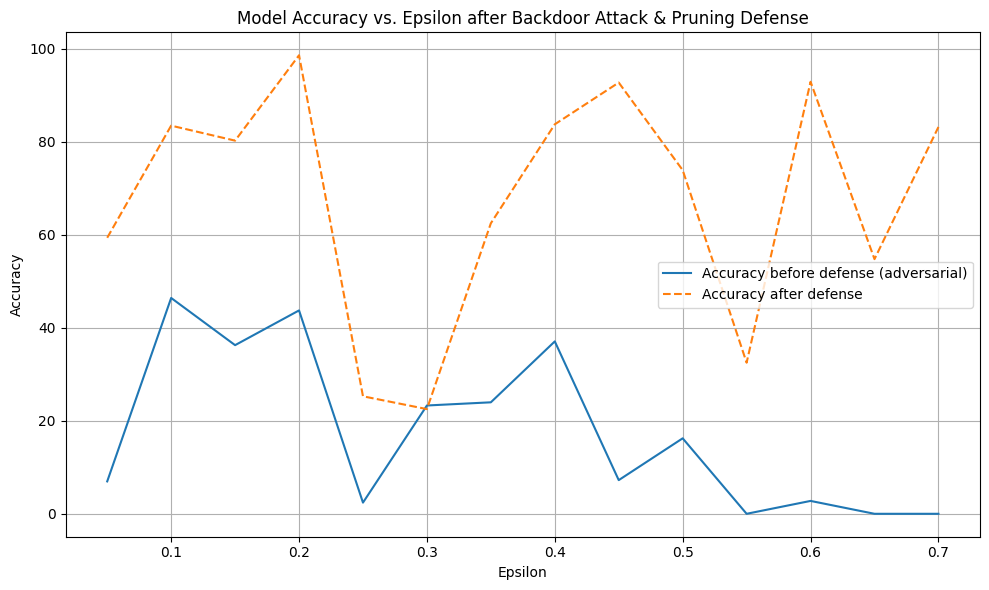

In [14]:
import matplotlib.pyplot as plt
range_attack = np.arange(0.05, 0.75, 0.05)
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(range_attack, accu_before_attack_list, label='Accuracy before defense (adversarial)')
plt.plot(range_attack, accu_after_defense_list , label='Accuracy after defense', linestyle='--')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Epsilon after Backdoor Attack & Pruning Defense')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()